# RTP Forecasting: CNN-LSTM
In this notebook, a full implementation of the CNN-LSTM model with the best hyperpaqrameters found after running search process in the `CNN_LSTM_model_keras_tuner.ipynb`.
We will consider three versions: one using 24 hours of lags, 48, and 72.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
def plot_predictions_models(pred_1,pred_2,pred_3, actual, title, time, filename, model_name, year=False):
    plt.figure(figsize=(15, 3), dpi=150)
    plt.plot(np.arange(len(pred_1)), np.array(actual),label='PF', alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_1),label=model_name+'-24',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_2),label=model_name+'-48',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_3),label=model_name+'-72',alpha=0.7)
    plt.legend(loc='upper right')
    plt.xlabel(time ,  fontsize=12)
    plt.ylabel('Price ($/MWh)' , fontsize=12)
    if year == True:
        if int(len(pred_1)/12)-len(pred_1)/12 == 0:
            plt.xticks(np.arange(0, len(pred_1) + int(len(pred_1)/12+1), int(len(pred_1)/12)+1), [str(i) for i in range(0, 13)])
        else:
            plt.xticks(np.arange(0, len(pred_1), int(len(pred_1)/12)), [str(i) for i in range(0, 13)])
    else:
        plt.xticks(np.arange(0, len(pred_1)+24, 24), [str(i) for i in range(0, int(len(pred_1)/24)+1)])
    plt.margins(x=0)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.title(title, fontsize=12)
    plt.savefig("figures/"+filename+".pdf", format="pdf", bbox_inches="tight")

In [7]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [8]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [9]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [10]:
raw_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,33.60,5065,32.28
2017-01-01 06:00:00+00:00,32.05,4934,30.77
2017-01-01 07:00:00+00:00,29.23,4812,31.17
2017-01-01 08:00:00+00:00,25.02,4728,32.00
2017-01-01 09:00:00+00:00,26.94,4665,27.89
...,...,...,...
2022-01-01 00:00:00+00:00,33.49,5362,30.21
2022-01-01 01:00:00+00:00,31.28,5139,30.23
2022-01-01 02:00:00+00:00,30.49,4943,30.34


In [11]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

In [12]:
log_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,3.361417,5065,5.143475
2017-01-01 06:00:00+00:00,3.306154,4934,5.134621
2017-01-01 07:00:00+00:00,3.197039,4812,5.136974
2017-01-01 08:00:00+00:00,3.008155,4728,5.141839
2017-01-01 09:00:00+00:00,3.098740,4665,5.117515
...,...,...,...
2022-01-01 00:00:00+00:00,3.357594,5362,5.131318
2022-01-01 01:00:00+00:00,3.277522,5139,5.131436
2022-01-01 02:00:00+00:00,3.247269,4943,5.132086


### Data Preprocessing

In [13]:
# Split dataset: 2017-2020 years for training and 2021 year for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [14]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


# Trtaining the best model
After we did extensive search for the best hyperparameters, we will retrain the best model for set of lags (24, 48, 72), to see how it will perform on testing and have a fair comparison when comparing the other models (CNN, LSTM). 

### Lag = 24

#### Reshape to (samples, steps, features)

In [16]:
n_steps_in = 24
n_steps_out = 24

x_train_cnn_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn_lstm.shape,y_train_cnn_lstm.shape,x_test_cnn_lstm.shape,y_test_cnn_lstm.shape)

(35017, 24, 3) (35017, 24, 1) (8713, 24, 3) (8713, 24, 1)


#### Tuned hyperparameters

In [17]:
# set hyperparameters (already tuned)
n_filters   = 40 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 1  # size for max pooling layers
n_cnn_lstm_unit = 32 # number of cnn_lstm units
activation  = 'tanh' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 50   # number of total epochs

#### Building the model

In [18]:
# define model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn_lstm.shape[1],x_train_cnn_lstm.shape[2]), activation=activation))
cnn_lstm_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn_lstm.shape[1],x_train_cnn_lstm.shape[2]), activation=activation))
cnn_lstm_model.add(MaxPooling1D(pool_size))
cnn_lstm_model.add(LSTM(n_cnn_lstm_unit, activation=activation))
cnn_lstm_model.add(Dense(n_cnn_lstm_unit, activation='linear'))
cnn_lstm_model.add(Dense(n_steps_out, activation='linear'))
cnn_lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 40)            400       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 40)             4840      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 40)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                9344      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                        

#### Running training

In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = cnn_lstm_model.fit(x_train_cnn_lstm, y_train_cnn_lstm, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/50
438/438 [==============================] - 7s 13ms/step - loss: 0.8718 - val_loss: 0.2360
Epoch 2/50
438/438 [==============================] - 6s 14ms/step - loss: 0.7852 - val_loss: 0.2205
Epoch 3/50
438/438 [==============================] - 7s 15ms/step - loss: 0.7292 - val_loss: 0.2197
Epoch 4/50
438/438 [==============================] - 6s 15ms/step - loss: 0.7199 - val_loss: 0.2169
Epoch 5/50
438/438 [==============================] - 6s 14ms/step - loss: 0.7173 - val_loss: 0.2165
Epoch 6/50
438/438 [==============================] - 6s 13ms/step - loss: 0.7007 - val_loss: 0.2101
Epoch 7/50
438/438 [==============================] - 5s 12ms/step - loss: 0.6786 - val_loss: 0.2062
Epoch 8/50
438/438 [==============================] - 5s 12ms/step - loss: 0.6922 - val_loss: 0.2089
Epoch 9/50
438/438 [==============================] - 5s 12ms/step - loss: 0.6995 - val_loss: 0.2036
Epoch 10/50
438/438 [==============================] - 5s 12ms/step - loss: 0.6808 - val_lo

#### Saving the model

In [18]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)
cnn_lstm_model.save(os.path.join(model_path,'cnn_lstm_model_best_24h.h5'))

### Lag = 48

We will do the same as we did above for the case with 24 lags, but now for 48. For simplicity, we made the whole process in one cell.

In [21]:
n_steps_in = 48
n_steps_out = 24

x_train_cnn_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn_lstm.shape,y_train_cnn_lstm.shape,x_test_cnn_lstm.shape,y_test_cnn_lstm.shape)

# set hyperparameters (already tuned)
n_filters   = 40 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 1  # size for average pooling layers
n_cnn_lstm_unit = 32 # number of cnn_lstm units
activation  = 'tanh' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 50   # number of total epochs

# Building the model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn_lstm.shape[1],x_train_cnn_lstm.shape[2]), activation=activation))
cnn_lstm_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn_lstm.shape[1],x_train_cnn_lstm.shape[2]), activation=activation))
cnn_lstm_model.add(MaxPooling1D(pool_size))
cnn_lstm_model.add(LSTM(n_cnn_lstm_unit, activation=activation))
cnn_lstm_model.add(Dense(n_cnn_lstm_unit, activation='linear'))
cnn_lstm_model.add(Dense(n_steps_out, activation='linear'))
cnn_lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cnn_lstm_model.summary()

# Running training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = cnn_lstm_model.fit(x_train_cnn_lstm, y_train_cnn_lstm, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)

# Saving the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)
cnn_lstm_model.save(os.path.join(model_path,'cnn_lstm_model_best_48h.h5'))

(34993, 48, 3) (34993, 24, 1) (8689, 48, 3) (8689, 24, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 24, 40)            400       
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 40)            4840      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 40)           0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 32)                9344      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 24)                792    

### Lag = 72

We will do the same as we did above for the case with 24 lags, but now for 72. For simplicity, we made the whole process in one cell.

In [22]:
n_steps_in = 72
n_steps_out = 24

x_train_cnn_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn_lstm.shape,y_train_cnn_lstm.shape,x_test_cnn_lstm.shape,y_test_cnn_lstm.shape)

# set hyperparameters (already tuned)
n_filters   = 40 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 1  # size for average pooling layers
n_cnn_lstm_unit = 32 # number of cnn_lstm units
activation  = 'tanh' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 32   # batch size
num_epochs     = 50   # number of total epochs

# Building the model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn_lstm.shape[1],x_train_cnn_lstm.shape[2]), activation=activation))
cnn_lstm_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn_lstm.shape[1],x_train_cnn_lstm.shape[2]), activation=activation))
cnn_lstm_model.add(MaxPooling1D(pool_size))
cnn_lstm_model.add(LSTM(n_cnn_lstm_unit, activation=activation))
cnn_lstm_model.add(Dense(n_cnn_lstm_unit, activation='linear'))
cnn_lstm_model.add(Dense(n_steps_out, activation='linear'))
cnn_lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cnn_lstm_model.summary()

# Running training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = cnn_lstm_model.fit(x_train_cnn_lstm, y_train_cnn_lstm, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)

# Saving the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)
cnn_lstm_model.save(os.path.join(model_path,'cnn_lstm_model_best_72h.h5'))

(34969, 72, 3) (34969, 24, 1) (8665, 72, 3) (8665, 24, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 36, 40)            400       
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 40)            4840      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 40)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 32)                9344      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 24)                792    

### Evaluate

Now, after we have trained and saved the best model for the three versions, we will evaluate them using the testing set

In [15]:
model_path = os.path.join(cwd,'saved_model')

In [16]:
n_steps_in = 24
n_steps_out = 24
x_test_cnn_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
cnn_lstm_model = load_model(os.path.join(model_path,'cnn_lstm_model_best_24h.h5'))
y_test_pred_24 = cnn_lstm_model.predict(x_test_cnn_lstm)

n_steps_in = 48
x_test_cnn_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_lstm_48 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
cnn_lstm_model = load_model(os.path.join(model_path,'cnn_lstm_model_best_48h.h5'))
y_test_pred_48 = cnn_lstm_model.predict(x_test_cnn_lstm)

n_steps_in = 72
x_test_cnn_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_lstm_72 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
cnn_lstm_model = load_model(os.path.join(model_path,'cnn_lstm_model_best_72h.h5'))
y_test_pred_72 = cnn_lstm_model.predict(x_test_cnn_lstm)


271/271 [==============================] - 1s 2ms/step


In [17]:
# Evaluation metrics
errors = y_test_pred_24 - y_test_cnn_lstm_24[:,:,0]
print('24h MAE: {:.4f}'.format(np.abs(errors).mean()))

errors = y_test_pred_48 - y_test_cnn_lstm_48[:,:,0]
print('48h MAE: {:.4f}'.format(np.abs(errors).mean()))

errors = y_test_pred_72 - y_test_cnn_lstm_72[:,:,0]
print('72h MAE: {:.4f}'.format(np.abs(errors).mean()))

24h MAE: 0.4538
48h MAE: 0.4386
72h MAE: 0.4596


### Rescale and evaluate performance

Now, we rescale the predictions to the actual values instead of the normalized to get a sense of the error

In [18]:
y_test_pred_rescale_24 = y_test_pred_24*y_std.values + y_mean.values
y_test_cnn_lstm_rescale_24 = y_test_cnn_lstm_24*y_std.values + y_mean.values
y_test_pred_invlog_24 = np.exp(y_test_pred_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_lstm_invlog_24 = np.exp(y_test_cnn_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_rescale_48 = y_test_pred_48*y_std.values + y_mean.values
y_test_cnn_lstm_rescale_48 = y_test_cnn_lstm_48*y_std.values + y_mean.values
y_test_pred_invlog_48 = np.exp(y_test_pred_rescale_48) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_lstm_invlog_48 = np.exp(y_test_cnn_lstm_rescale_48) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_rescale_72 = y_test_pred_72*y_std.values + y_mean.values
y_test_cnn_lstm_rescale_72 = y_test_cnn_lstm_72*y_std.values + y_mean.values
y_test_pred_invlog_72 = np.exp(y_test_pred_rescale_72) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_lstm_invlog_72 = np.exp(y_test_cnn_lstm_rescale_72) -1 + min(raw_data.loc[:,"RTP"])

In [19]:
# Evaluation metrics
# 24 hours ahead
# Evaluation metrics
errors = y_test_pred_invlog_24 - y_test_cnn_lstm_invlog_24[:,:,0]
print('24h MAE: {:.4f}'.format(np.abs(errors).mean()))

errors = y_test_pred_invlog_48 - y_test_cnn_lstm_invlog_48[:,:,0]
print('48h MAE: {:.4f}'.format(np.abs(errors).mean()))

errors = y_test_pred_invlog_72 - y_test_cnn_lstm_invlog_72[:,:,0]
print('72h MAE: {:.4f}'.format(np.abs(errors).mean()))


24h MAE: 11.6092
48h MAE: 11.1771
72h MAE: 11.6884


Some visualization for the predictions to have a better picture.

Both figures show a snapshot of the prediction for one month of the testing set. PF means Perfect Forecast, which is the ground truth.

The predictions are made in a rolling window fashio, so for each hour we will have a 24 hours ahead predictions. To show that in the visualization, the top figure only showing the first hour prediction for each time stamp, while for the bottom figure it shows the 24 hours prediction for  a fixed time (one hour per day, showing its 24 hours predictions then jumping to the next dat and do on)

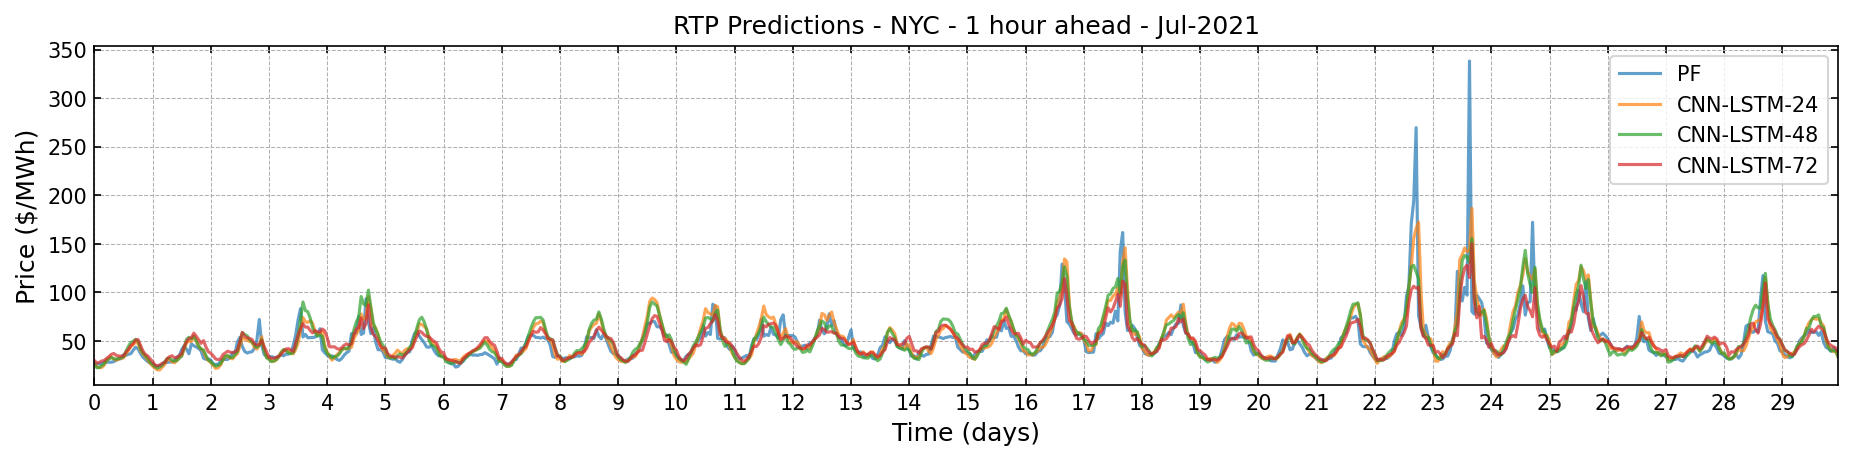

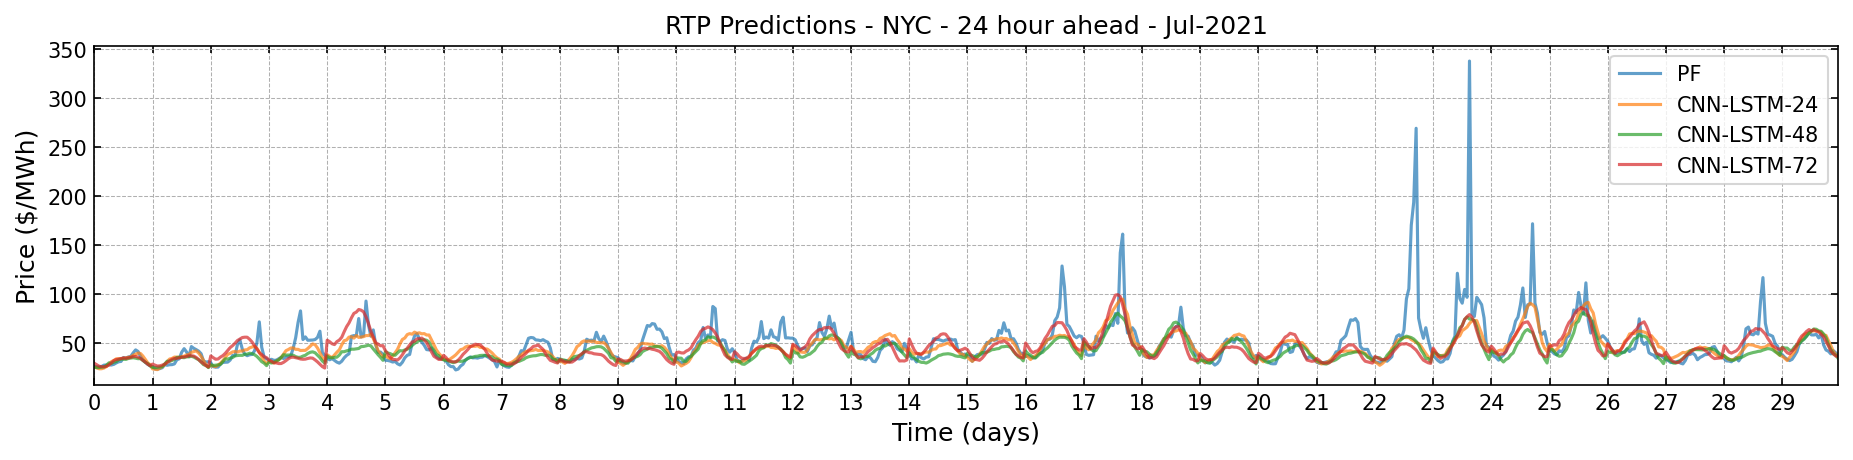

In [20]:
i = 7*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_invlog_24[i+48:j+48,0].flatten(),
                       y_test_pred_invlog_48[i+24:j+24,0].flatten(),
                       y_test_pred_invlog_72[i:j,0].flatten(),
                       y_test_cnn_lstm_invlog_72[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021', 'Time (days)',
                       'cnn_lstm_hourly_predictions_jul_all_lags', 'CNN-LSTM')

plot_predictions_models(y_test_pred_invlog_24[i+48:j+48:24,:].flatten(),
                       y_test_pred_invlog_48[i+24:j+24:24,:].flatten(),
                       y_test_pred_invlog_72[i:j:24,:].flatten(),
                       y_test_cnn_lstm_invlog_72[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021', 'Time (days)',
                       'cnn_lstm_24ha_predictions_jul_all_lags', 'CNN-LSTM')

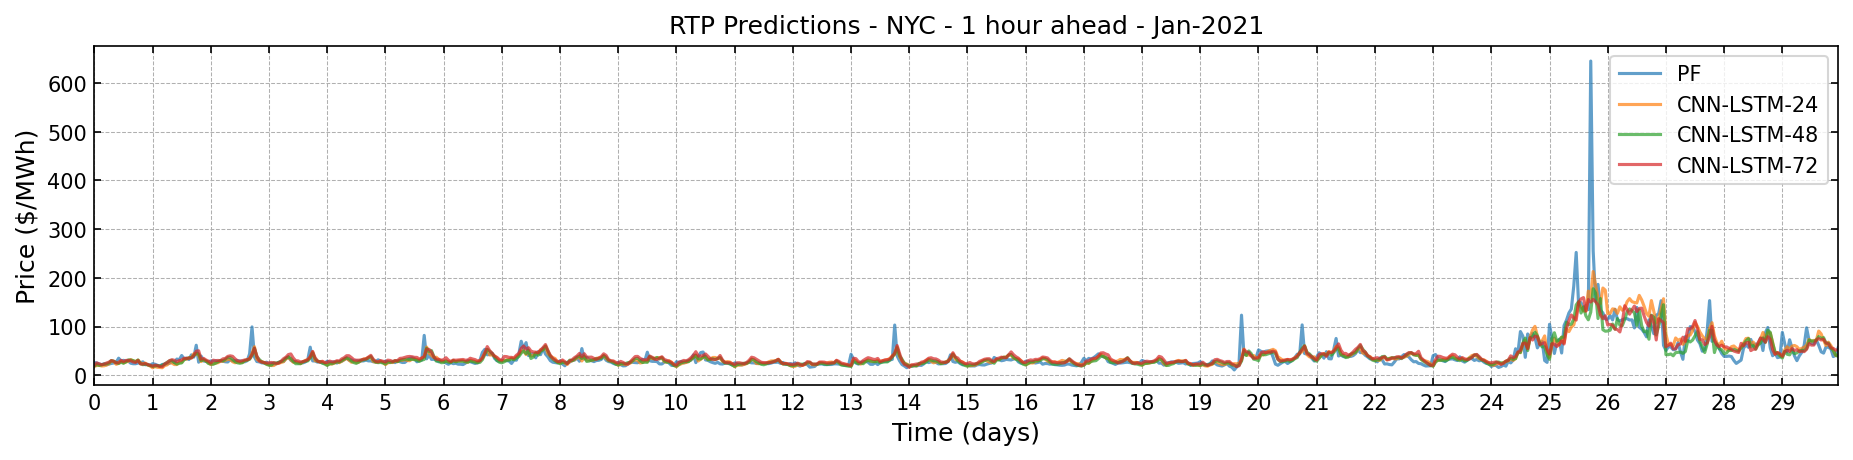

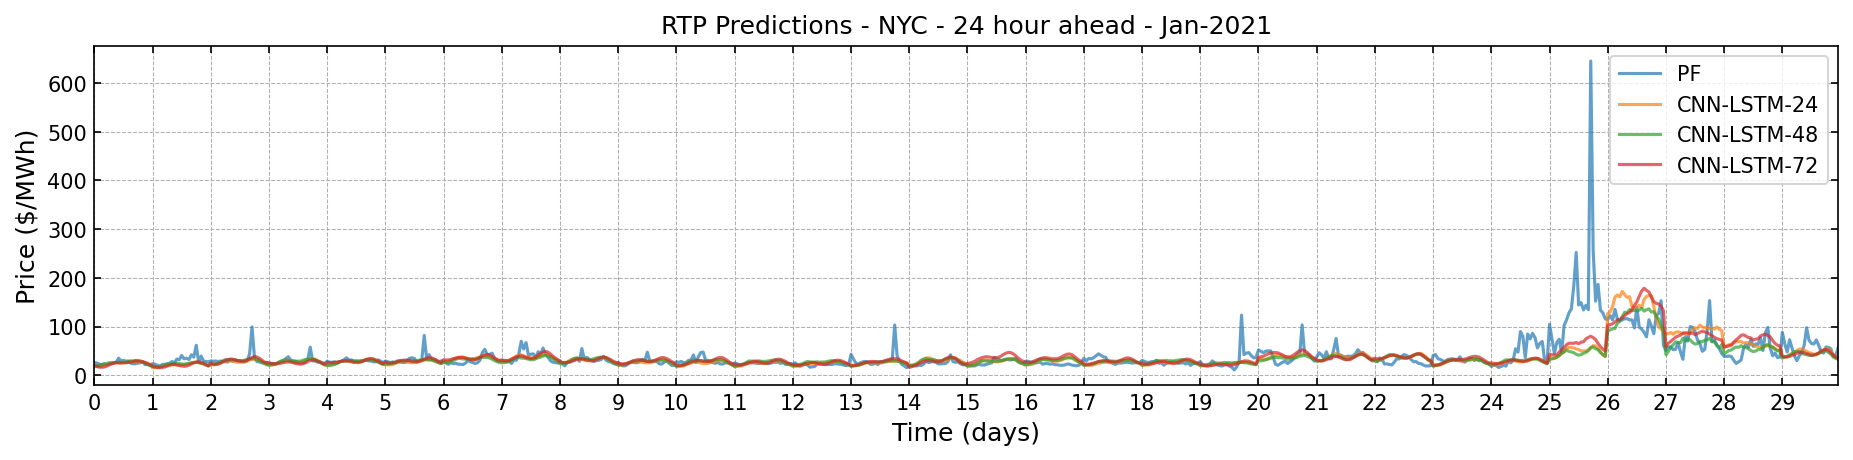

In [21]:
i = 0*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_invlog_24[i+48:j+48,0].flatten(),
                       y_test_pred_invlog_48[i+24:j+24,0].flatten(),
                       y_test_pred_invlog_72[i:j,0].flatten(),
                       y_test_cnn_lstm_invlog_72[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021', 'Time (days)',
                       'cnn_LSTM_hourly_predictions_jan_all_lags', 'CNN-LSTM')

plot_predictions_models(y_test_pred_invlog_24[i+48:j+48:24,:].flatten(),
                       y_test_pred_invlog_48[i+24:j+24:24,:].flatten(),
                       y_test_pred_invlog_72[i:j:24,:].flatten(),
                       y_test_cnn_lstm_invlog_72[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021', 'Time (days)',
                       'cnn_LSTM_24ha_predictions_jan_all_lags', 'CNN-LSTM')